<p style="font-family:Times;font-size:175%; text-align:center"> <font color='green'>Pemodelan dan Prediksi Harga Saham Menggunakan Neural Network: Kasus Hawlett-Packard Enterprise</font></p>

___

Hewlett Packard Enterprise Company adalah perusahaan teknologi informasi perusahaan multinasional Amerika yang berbasis di San Jose, California, didirikan pada tanggal 1 November 2015, sebagai bagian dari pemisahan perusahaan Hewlett-Packard. 

>* Data saham HPE yang digunakan adalah antara tanggal 12 Oktober 2015 sampai 22 Februari 2021.

>* Digunakan 1307 data dengan 1000 data untuk training dan 307 data untuk testing.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:5.4f}'.format})

# Sigmoid function
sigmoid = lambda Z: 1 / (1+np.exp(-Z))
dsigmoid = lambda A: A * (1-A) # Derivative

# Rectified Linear Unit (ReLU) function
rectified = lambda Z: np.maximum(0.0, Z)
drectified = lambda A: (A > 0) * 1.0

# Linear function
linear = lambda X, w, b: np.dot(X, w) + b

# Time step (ts)
def steps(x, step):   
    obs = len(x) - step
    xt = x[:obs,:]
    for i in np.arange(1, step+1):
        xt = np.hstack((xt, x[i:obs+i,:]))   
    return xt

## Mendefinisikan kelas NeuralNetwork

In [2]:
class NeuralNetwork:
    
    def __init__(self, x, y, hlayers, alpha): # ada h nodes di dalam hidden layer
        self.X = x #input
        self.y = y #output
        self.α = alpha
        
        # Mengecek tipe data input
        assert np.ndim(y) == 2
        assert type(hlayers) == list
        
        ni = np.shape(x)[1]  # jumlah features
        self.N, no = np.shape(y)   # jumlah observasi, jumlah output
        
        neurons = [ni]
        neurons.extend(hlayers)
        neurons.append(no)   #jumlah neurons per layer, termasuk input layer 
        self.nlayers = len(neurons) - 1  #number of layers (tidak termasuk input layer)

        "Initial values untuk parameter w and b"
        self.w, self.b = [], []
        for i in np.arange(self.nlayers):
            self.w.append(np.random.randn(neurons[i], neurons[i+1]))  #Sinapsis dari layer ke i menuju layer ke (i+1)
            self.b.append(np.random.randn(1, neurons[i+1]))           #Bias di layer ke (i+1)    
            
    def forward_propagation(self, X, y):
        "Forward propagation (perambatan maju)"
        N = np.shape(y)[0]
        Z, A = [], [X]
        for j in np.arange(self.nlayers):
            Z.append(linear(A[j], self.w[j], self.b[j]))  #Reaksi kimia di layer ke (j + 1)
            A.append(sigmoid(Z[j]))     #Aliran listrik di layer ke (j + 1)
    
        y_predicted = A[self.nlayers]
        e = y - y_predicted
        Cost = np.dot(e.T, e) / (N - 0.000001)  #mean squared error
        
#         print('MSE: %8.7f'%self.Cost)
        return Z, A, y_predicted, Cost, e

    def training(self):
        
        "Forward propagation (perambatan maju)"
        Z, A, y_predicted, Cost, e = self.forward_propagation(self.X, self.y)
        self.training_cost = Cost
        self.y_train_hat = y_predicted

        "Backward propagation (perambatan mundur)"
    
        dCdZ = [(-2 * e / self.N) * dsigmoid(A[::-1][0])]  #dalam bentuk list agar bisa di-append,
                                                     #dimulai dari layer terakhir 
        for m in np.arange(self.nlayers - 1):  #dan mundur ke layer berikutnya, sampai hidden layer pertama
            dCdZ.append( np.dot(dCdZ[m], self.w[::-1][m].T) * dsigmoid(A[::-1][m+1]) )   #delta
        
        "Perubahan parameters (w dan b):"
    
        one = np.ones([1, self.N])
        dCdw, dCdb = [], []   #dalam bentuk list agar bisa di-append
    
        for n in np.arange(self.nlayers): 
            "Algoritma gradient descents"
        
            dCdw.append( np.dot(A[n].T, dCdZ[::-1][n]) )  #Dapatkan gradients untuk w dari dCdZ
            self.w[n] -= self.α * dCdw[n]   #Parameter w di-update 
        
            dCdb.append( np.dot(one, dCdZ[::-1][n]) )     #Dapatkan gradients untuk b dari dCdZ
            self.b[n] -= self.α * dCdb[n]   #Parameter b di-update
            
    def testing(self, X_test, y_test):
        Z, A, y_predicted, cost, e = self.forward_propagation(X_test, y_test)
        self.y_test_hat = y_predicted
        self.testing_cost = cost

## Memprediksi Saham HPE

TRAINING MODEL...
==================================================================================================== 100 %
MSE training: 0.0004850
                        Epoch       MSE
Time                                   
0 days 00:00:02.358998   2000  0.001664
0 days 00:00:04.774998   4000  0.001107
0 days 00:00:06.481044   6000  0.000726
0 days 00:00:08.478005   8000  0.000540
0 days 00:00:10.160995  10000  0.000485

TESTING MODEL...
MSE testing: 0.0007873


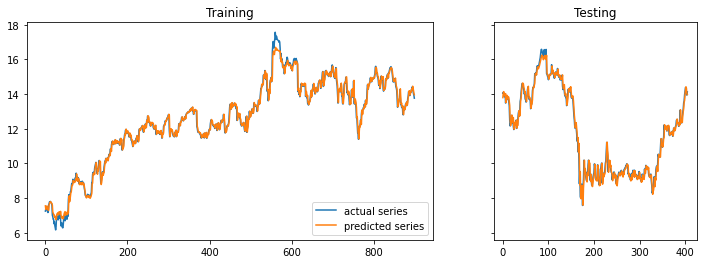


Time passed for training and testing: 0:00:11.348012


In [3]:
# url = "https://query1.finance.yahoo.com/v7/finance/download/HPE?period1=1449705600&period2=1613952000&interval=1d&events=history&includeAdjustedClose=true"
url = "HPE.csv"
A  = pd.read_csv(url)
A_adjclose = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A_adjclose[:, np.newaxis]  
Bmax = B.max()
Bmin = B.min()

# Normalisasi data menjadi antara -1 dan 1
b = (B - Bmin) / (Bmax - Bmin)

ts = 1 # jarak data yang akan diprediksi, di hari ke-i (variabel x), akan diprediksi data hari ke-(i+ts) (variabel y)
xt = steps(b, ts)  # matriks dengan (ts+1) kolom, kolom pertama menjadi variabel X
                   # dan kolom terkhir menjadi variabel y

x = xt[:,:] # ambil semua data
div = 900
# Data untuk training
X = x[0:div, :-1]  #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
y = x[0:div:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

# Data untuk testing
Xtest = x[div:, :-1]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[div:, -1:]   #ambil kolom terakhir

# Menentukkan banyaknya hidden layers
hlayers = [4, 2]  # Dua hidden layers, masing-masing dengan 4 neurons dan 2 neurons
alpha   = 6 # learning rate
epochs  = 10000

np.random.seed(20210222)

tic = datetime.now()

# TRAINING
print("TRAINING MODEL...")
mse = []
ann = NeuralNetwork(X, y, hlayers, alpha)
for t in range(epochs): 
    ann.training()
    if (t+1)%(epochs/10) == 0:   #tampilkan output lima kali
#         print( "{0} \t|\t {1} \t\t|\t {2:7.7f}".format(datetime.now()-tic, t+1, ann.training_cost[0][0]) )
        progress = int((t+1)/epochs*100)
        print("="*progress, progress, "%", end="\r")
        mse.append([datetime.now()-tic, t+1, ann.training_cost[0][0]])
        
print('\nMSE training: %7.7f'%ann.training_cost)
training_table = pd.DataFrame(mse[1::2], columns=["Time", "Epoch", "MSE"])
training_table.set_index('Time', inplace=True)
print(training_table)

# TESTING
print("\nTESTING MODEL...")
ann.testing(Xtest, ytest)
print('MSE testing: %7.7f'%ann.testing_cost)


# Mengembalikan skala data ke original unit dalam satuan dolar
y_train = y * (Bmax - Bmin) + Bmin
y_train_hat = ann.y_train_hat * (Bmax - Bmin) + Bmin
ytesto = ytest * (Bmax - Bmin) + Bmin
ytesthato = ann.y_test_hat * (Bmax - Bmin) + Bmin

# Plot
wr1 = int(div/len(x)*10)
wr2 = int((len(x)-div)/len(x)*10)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'width_ratios': [wr1, wr2]})

ax[0].set_title('Training')
ax[0].plot(y_train, label = 'actual series')
ax[0].plot(y_train_hat, label = 'predicted series')
ax[1].set_title('Testing')
ax[1].plot(ytesto, label='actual series')
ax[1].plot(ytesthato, label='predicted series')
ax[0].legend(loc='lower right')
plt.show()

print("\nTime passed for training and testing: {}".format(datetime.now()-tic))

In [4]:
print("Parameter w:")
print(ann.w)
print("Parameter b:")
print(ann.b)

Parameter w:
[array([[-4.5912, 4.8542, 1.5188, -3.5605]]), array([[1.4622, 3.0664],
       [-3.5857, -2.8876],
       [-1.3020, -0.9478],
       [0.8548, 2.2919]]), array([[-3.7881],
       [-5.5899]])]
Parameter b:
[array([[-0.5734, -5.0079, -1.9762, -0.7941]]), array([[1.2671, -1.1305]]), array([[3.9353]])]
